# Planet Labs Object Detection

The goal of this work is to show how one might extract regions of interest, perform change detection, and feature extraction from Planet Labs imagery while doing so in a reproducable way series of sharable code snippets. 

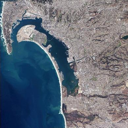

In [1]:
from timbr import Snapshot
from IPython.display import Image, display
import base64 as b64

data = Snapshot("/Users/chelm/.timbr/data/San Diego Image Metadata (Planet Labs - RapidEye).h5")

scene_ids = [
    "20160324_190655_1154114_RapidEye-3",
    "20150326_192901_1154114_RapidEye-5",
    "20140403_193228_1154114_RapidEye-5",
    "20131125_192646_1154114_RapidEye-5",
    "20151212_191210_1154114_RapidEye-5"
]

scenes     = {s['id']: s for i, s in data }                   
scene_meta = [ scenes[i] for i in scene_ids ]

display(Image(data=b64.b64decode(scene_meta[-1]["thumbnail"]["__data__"]), width=250, height=250))  


In [2]:
from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response

opener = urllib2.build_opener(NoRedirection)

def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            
            
scenes     = {s['id']: s for i, s in data }
api_key    = "65a347d4358348189a800a5eac3bcde7"
data_dir   = './san_diego_4_11_16/'
scene_type = 'visual'                    
scene_meta = [ scenes[i] for i in scene_ids ]
    
for scene in scene_meta:
    filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
    if not os.path.exists(filename):
        get_image(scene, scene_type=scene_type, data_dir=data_dir)
        
    sys.stdout.write('Found %s \n' % (filename,))
     

Found ./san_diego_4_11_16/visual/20160324_190655_1154114_RapidEye-3_visual.tif 
Found ./san_diego_4_11_16/visual/20150326_192901_1154114_RapidEye-5_visual.tif 
Found ./san_diego_4_11_16/visual/20140403_193228_1154114_RapidEye-5_visual.tif 
Found ./san_diego_4_11_16/visual/20131125_192646_1154114_RapidEye-5_visual.tif 
Found ./san_diego_4_11_16/visual/20151212_191210_1154114_RapidEye-5_visual.tif 


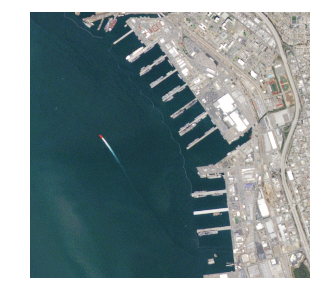

In [3]:
import os
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def render_array(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')

def xy_from_coords(x_coord, y_coord, ul, lr, width, height):
    x0, x1 = ul[0], lr[0]
    y0, y1 = ul[1], lr[1]
    x_diff = x1 - x0
    y_diff = y0 - y1
    xpx =  ((x1 - x_coord) / x_diff) * width
    if y0 - y_coord == 0.0:
        ypx = height
    elif y_diff != 0:
        ypx = (y0 - y_coord) / y_diff * height
    else:
        ypx = 0
    return int(abs(xpx-width)), int(ypx)


def clip_image(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            ul, lr = [bounds.left, bounds.top], [bounds.right, bounds.bottom]
            r, g, b, a = src.read()
            np_img = np.dstack((r, g, b, a))
            ul_px = xy_from_coords(bbox[0], bbox[3], ul, lr, src.width, src.height)
            lr_px = xy_from_coords(bbox[2], bbox[1], ul, lr, src.width, src.height)
            return np_img[ul_px[0]:lr_px[0], ul_px[1]:lr_px[1], :]
        

def clip_directory(data_dir, bbox):
    files = os.listdir(data_dir)
    return [clip_image(bbox, os.path.join( data_dir, f )) for f in files]
    

bbox = [483275.7009112152, 3610083.6489744713, 486785.39847831125, 3613762.760762966]
data_dir = './san_diego_4_11_16/visual/'

clipped = clip_directory(data_dir, bbox)

fig, ax = plt.subplots(1, figsize=(5,5), facecolor='white')
ax.axis('off')
imgplot = plt.imshow(clipped[-1])
plt.show() 


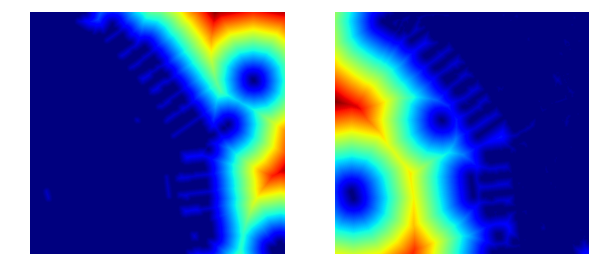

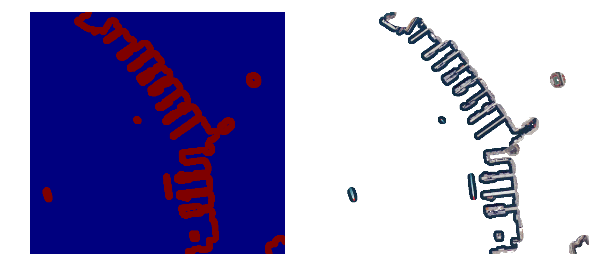

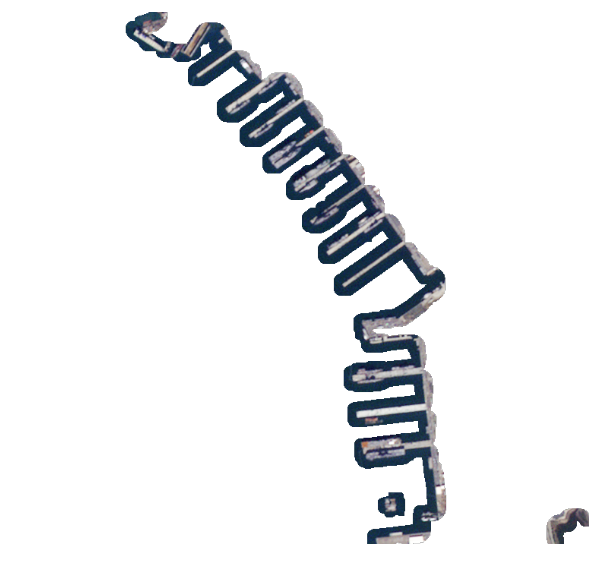

In [5]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


def buffer_coastline(img, threshold=135):
    arr = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.ndarray(arr.shape + (3,)).astype(np.uint8)
    below = arr < threshold
    mask[below] = [255,255,255]
    mask = cv2.morphologyEx(mask[:,:,0], cv2.MORPH_OPEN, kernel=np.ones([3, 3]), iterations=3)
    edm1 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    edm2 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm2 < 20) & (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    return mask, edm1, edm2


def render_array(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')
                          
            
img = clipped[3][:,:,0:3].copy()
mask, edm1, edm2 = buffer_coastline(img.copy())
render_array(edm1, edm2, width=10, height=10)

img = clipped[3].copy()
img[:,:,3] = mask
render_array(img, mask, width=10, height=10)

masks = []
for image_arr in clipped:
    mask, edm1, edm2 = buffer_coastline(image_arr, threshold=125)
    masks.append(mask)
    
union_mask = reduce( lambda s,e: s & e, masks )
union_mask = cv2.dilate(union_mask, kernel=np.ones([3, 3]), iterations=3)
binary_mask = union_mask.copy() 
binary_mask[(union_mask > 0)] = 1

img = clipped[3].copy()
img[:,:,3] = union_mask

render_array(img, width=10, height=10)

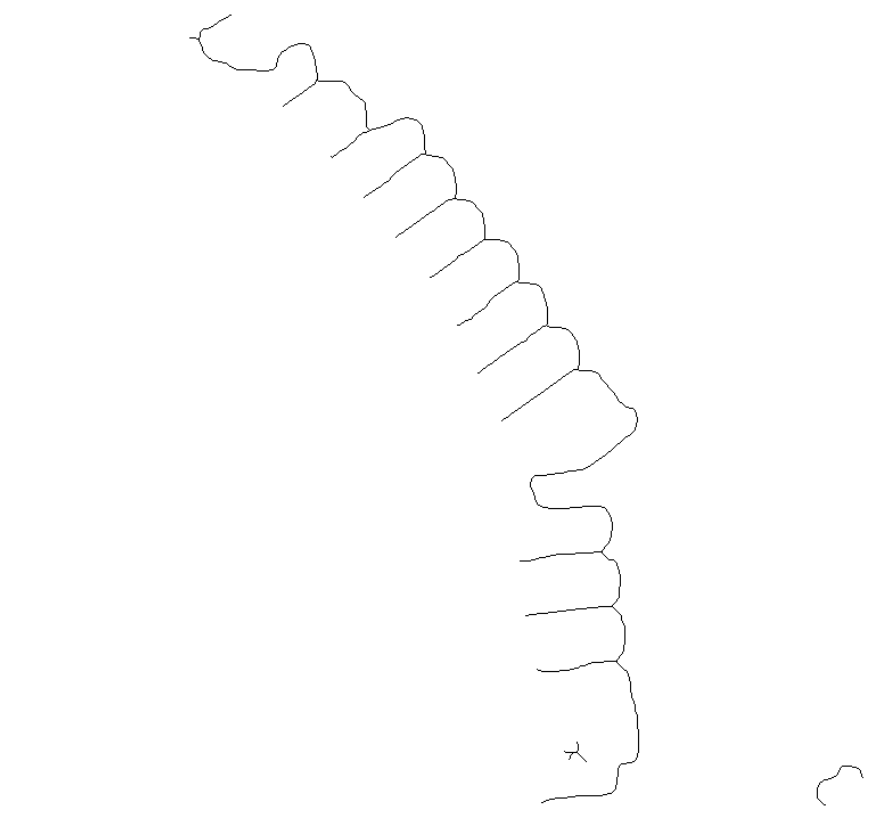

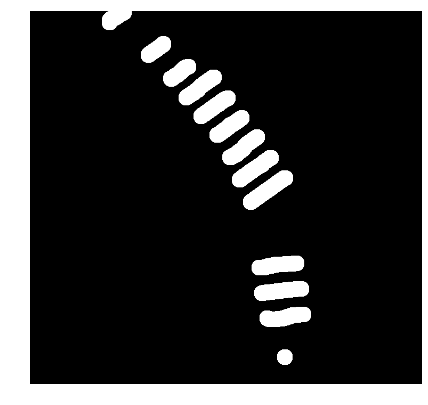

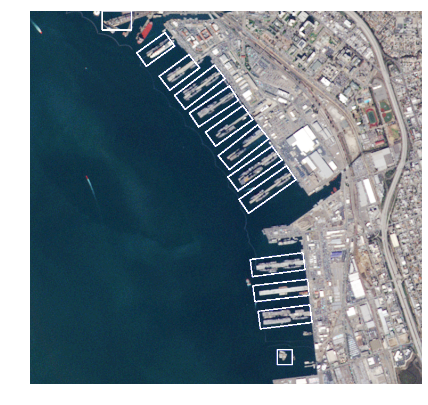

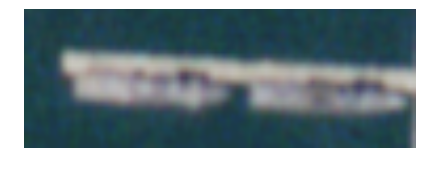

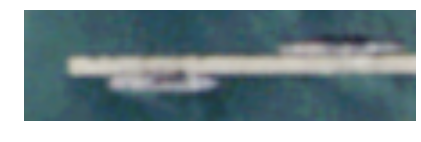

In [7]:
import numpy as np
import cv2

from skimage import measure
from skimage.measure import regionprops
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, opening
from scipy import ndimage

def seg_buffer(im, dist=25):
    mask = im.copy()
    edm1 = cv2.distanceTransform(~im, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < dist)
    mask[s] = 1
    return mask, edm1

skel = skeletonize(binary_mask).astype(np.int)
render_array(~skel, width=15, height=15, cmap=plt.cm.gray)

k = np.array([[1,1,1],[1,0,1],[1,1,1]])
ngrid = ndimage.convolve(skel, k, mode='constant') * skel
ngrid[ngrid > 2] = 0
ngrid[(ngrid <= 2) & (ngrid > 0)] = 1

segment_labels = measure.label(ngrid)
segment_props = measure.regionprops(segment_labels)

i=0
buffers = []
for seg in segment_props:
    i += 1
    if (seg.orientation < 0 
        or seg.orientation > 1 
        or seg.solidity < 0.1):
        continue

    buff, edm1 = seg_buffer((segment_labels == i).astype(np.uint8) * 255, dist=15)
    buffers.append(buff)

buffer_sum = reduce( lambda s,e: s + e, buffers )

contours, hierarchy = cv2.findContours( buffer_sum.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
vis = clipped[0].copy()

regions = []
for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) > 0.0:
        rect = cv2.minAreaRect(cnt)
        box = cv2.cv.BoxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(vis,[box],0,(0,0,255),2)
        regions.append({ 'box': box, 'rect': rect, 'bounds': cv2.boundingRect(cnt)})

render_array(buffer_sum, cmap=plt.cm.gray)
render_array(vis)

def crop_region(region, img):
    rect = region['rect']
    center = rect[0]
    angle = rect[2]
    size = rect[1]
    size = (int(size[0]), int(size[1]))
     
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    warped = cv2.warpAffine(img, M, dsize=img[:,:,0].shape, flags=cv2.INTER_CUBIC)
    crop = np.ndarray((size[1],size[0],4))

    for i in xrange(4):
        crop[:,:,i] = cv2.getRectSubPix(warped[:,:,i], size, center)

    return crop.astype(np.uint8)


image_regions = [[crop_region(region, img.copy()) for region in regions[1:-2]] for img in clipped]
render_array(image_regions[4][5])
render_array(image_regions[1][3])

# Dock/Land Masking
We use each image to remove everything permanent (land and docks) from the imagery. To do this we use a series of masking technigues that become unioned into a final "region_mask" the can be used to segment boats from docks.

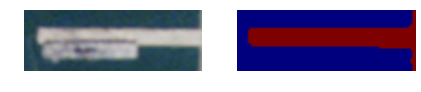

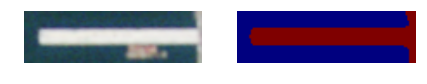

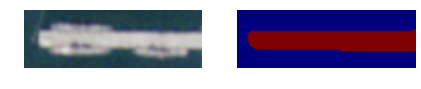

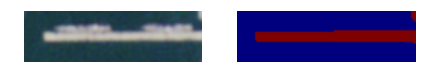

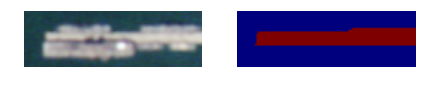

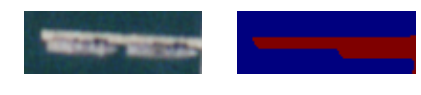

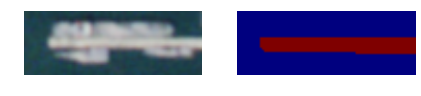

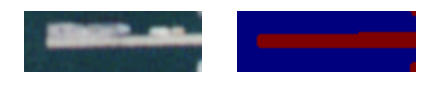

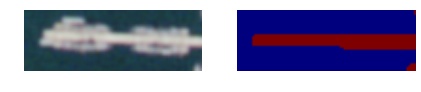

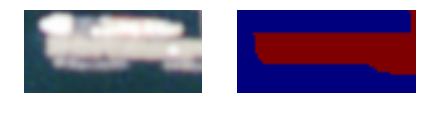

In [8]:
normalize = lambda x: (255 / (x.max() - x.min())) * (x - x.min())
smooth = lambda x: ndimage.convolve(x, np.ones([3,3])/9)

def threshold_mask(img, threshold=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.ones(gray.shape).astype(np.uint8)
    mask[gray < threshold] = 0
    return mask

def scanline_mask(imask):
    mask = np.ndarray(imask.shape)

    for l in xrange(imask.shape[0]):
        line = imask[l,:]
        labels = measure.label(line)
        land = labels[-1]
        if land == 1:
            mask[l,:] = labels
        else:
            labels[ labels != land ] = 0
            labels[ labels > 0 ] = 1
            mask[l,:] = labels

    return (mask >= 1).astype(np.uint8)


def saturation_mask(img, threshold=170):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    normS = ndimage.convolve(~smooth(gray[:,:,1]), np.ones([3,3])/9)
    mask = normS > threshold
    return mask
    

region_masks_all = []
region_masks = []
for r in xrange(len(image_regions[0])):
    _masks = []
    for i in xrange(len(image_regions)):
        img = image_regions[4][r].copy()
        mask = saturation_mask( img )
        _masks.append( mask )
        
    region_masks_all.append(_masks)
    r_mask = scanline_mask( reduce( lambda s,e: s + e, _masks ) )
    render_array(r_mask, image_regions[4][r])
    region_masks.append(r_mask)

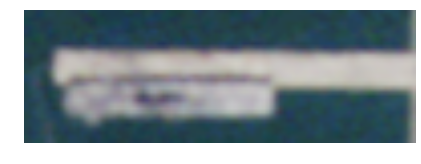

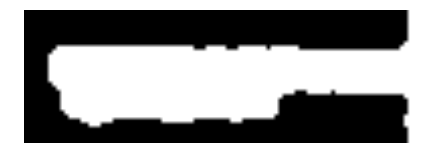

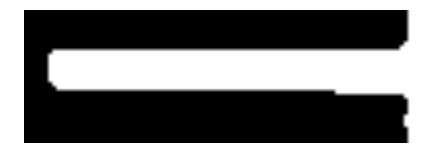

In [9]:
r = 0
img = image_regions[4][r].copy()
render_array(img)
smask = saturation_mask(img)
render_array(smask, cmap=plt.cm.gray)
render_array(scanline_mask(smask), cmap=plt.cm.gray)

# Counting Boats at Docks

To count boats we agin employ a series of masking techniques. First we take a region mask that has info on the location of any land and the dock (permanent features) and subtract that from a thresholded image (water vs. non-water). This results in a mask that contains the temporary features for the given image.

Each feature is labeled and then contoured to collect size and bounding area data, and then they're saved in a dictionary that can be used to summerize the results. 

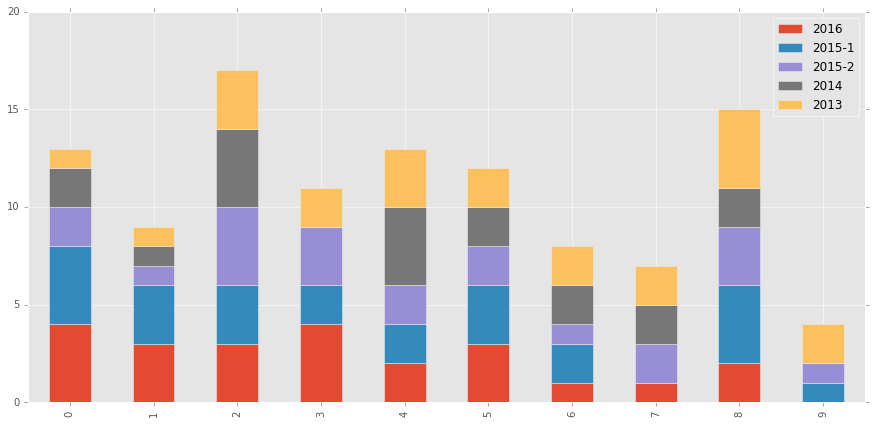

Region: 3
image: 0 Objects: 4


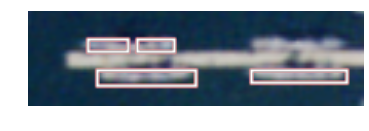

image: 1 Objects: 2


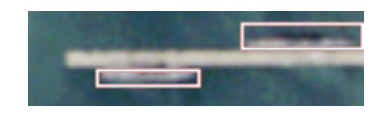

image: 2 Objects: 3


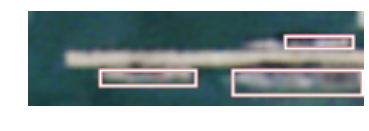

image: 3 Objects: 0


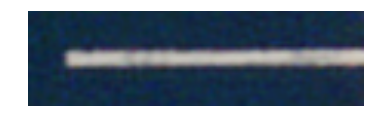

image: 4 Objects: 2


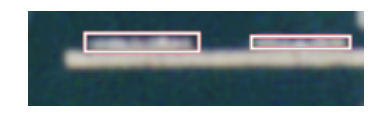

In [11]:
import cv2
from skimage.morphology import binary_opening

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


def show_region(r):
    print 'Region:', r
    counts = []
    for i, image in enumerate(image_regions): 
        objects = found_objects[i][r]
        print 'image:', i, 'Objects:', objects['count']
        counts.append(objects['count'])
        vis = image[r].copy()
        for cnt in objects['contours']:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),1)
        render_array(vis, width=6, height=6)    


def find_objects(r, r_img, show=False):
    vis = r_img.copy()
    t_mask = saturation_mask( r_img, threshold=threshold )

    mask = region_masks[r].copy()
    diff = mask - t_mask
    diff[ diff < 255 ] = 0
    diff = binary_opening(diff).astype(np.uint8)
    
    labels = measure.label(diff)
    props = measure.regionprops(labels)
    
    if show == True:
        render_array(vis, r_img, width=10, height=10)
        #render_array(r_img)
    
    contours, hierarchy = cv2.findContours(diff.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = []
    areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 20.0: 
            areas.append(area)
            filter_contours.append(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),1)
            #cv2.drawContours(vis, cnt, -1, (255,0,0), 2)
            
    return filter_contours, areas
    
threshold = 170    
found_objects = []
for i, regions in enumerate(image_regions):
    region_objs = []
    for r, img in enumerate(regions):
        contours, areas = find_objects(r, img.copy())
        cnt = len(contours)
        
        region_objs.append({'areas': areas, 'contours': contours, 'count': cnt})
    found_objects.append(region_objs) 
    

cnts = [[o['count'] for o in img] for img in found_objects]

df2 = pd.DataFrame(np.array(cnts).transpose(), columns=['2016', '2015-1', '2015-2', '2014','2013'])
df2.plot.bar(figsize=(15, 7), width=.5, ylim=(0,20), stacked=True)
plt.show()

show_region(3)

#c,a = find_objects(1, image_regions[4][1], show=True)
#c,a = find_objects(5, image_regions[4][5], show=True)
#c,a = find_objects(0, image_regions[3][0], show=True)
#time.sleep(1)
#show_region(3)

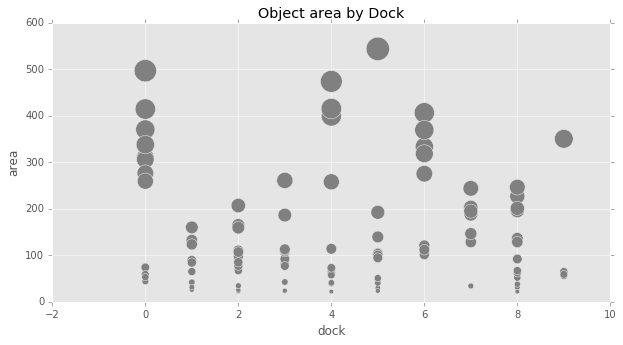

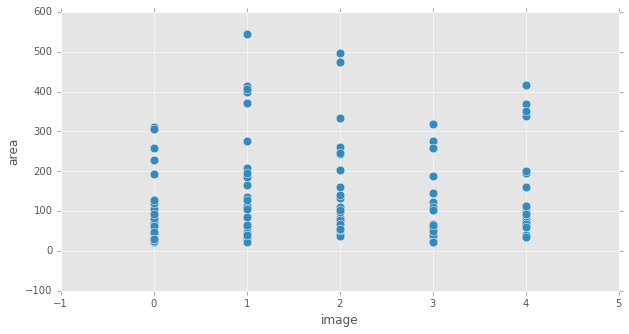

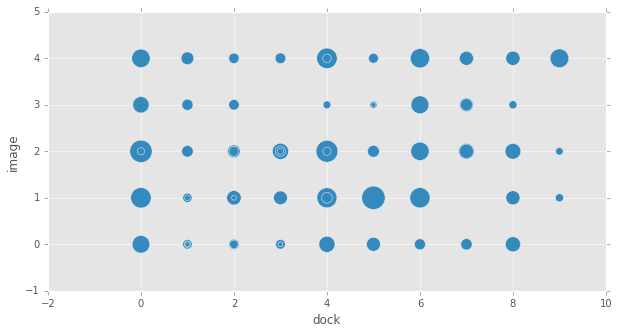

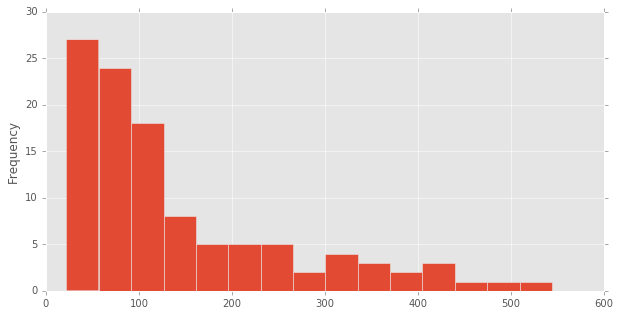

In [126]:
import pandas as pd

areas = []
for i, img in enumerate(found_objects):
    for r, reg in enumerate(img):
        for cnt in reg['contours']:
            areas.append((cv2.contourArea(cnt), r, i))
            
df = pd.DataFrame(data = areas, columns=['area', 'dock', 'image'])

df.plot(kind='scatter', x='dock', y='area', figsize=(10, 5), c='gray', s=df['area'], ylim=(0,600), title="Object area by Dock")
df.plot(kind='scatter', x='image', y='area', figsize=(10, 5), s=75)
df.plot(kind='scatter', x='dock', y='image', figsize=(10, 5), s=df['area'])

plt.figure();
df['area'].plot(kind='hist', bins=15, figsize=(10, 5), x='Area')
plt.show()